# Part 3 - Digging deeper into spatial analysis

**ETA** : 20-60 min

**Main Topics** : 
0. (Data Assessment)
1. Spatial Enrichment of biological pathways
2. Expression by distance
3. Increased spatial resolution (Primer)


**Information** : This final part will not adhere to the same structured workflow as the two previous parts, rather it's designed to _expose_ you to some different ideas or concepts that could (theoretically) be applied to any type of spatial data. 

I strongly recommend you to work through the topics in sequential order; still, they are modular and independent (except the data assessment) so you can "jump between them", if you prefer that. You might see that topic 3 is marked as a "primer"; in short this means that the exercise is constructed to spark some interest for the topic rather than being a complete analysis in itself.

To spice things up a bit and not use the same data over and over again, we'll also switch from Human breast cancer to a slightly different tissue, namely mouse brain.


**Data** : Mouse Brain (Sagittal Posterior). Accessible at 10X Genomics [website][1].


[1]:http://cf.10xgenomics.com/samples/spatial-exp/1.0.0/V1_Mouse_Brain_Sagittal_Posterior_Section_2/V1_Mouse_Brain_Sagittal_Posterior_Section_2_web_summary.html

In [45]:
#------NON-CONCEPTUAL------#
# begin by loading the different packages that we will be using


import anndata as ad
import numpy as np
import pandas as pd

import funcs as f

import matplotlib.pyplot as plt

from typing import Tuple,Union, List, Dict

import torch as t
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import anndata as ad
from scipy.spatial.distance import cdist


from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [46]:
# load data; we will begin with just one sample for the sake of convenience 
data_pths = dict(sample_1 = "../data/mouse-brain/curated/mouse-brain.h5ad")
data = ad.read_h5ad(data_pths["sample_1"])


## 0. Assessing the data

To give you some context, we quickly assess the data to familiarize ourselves with the morphology and the spatial structures that are present. We follow the same procedure as in Part 1 and 2, that is:

1. Inspect the data object
2. Inspect the spatial arrangement of the spots
3. Normalize, Reduce Dimensionality, Cluster the data based on gene expression

Since we've been through this procedure (twice) before, I'm going to be fairly sparse with comments.

In [47]:
# We inspect the data object just to make sure everythin loaded correctly
display(data)

AnnData object with n_obs × n_vars = 3293 × 31017
    obs: 'barcodes', 'under_tissue', '_x', '_y', 'x', 'y'
    var: 'name', 'id', 'n_counts'
    uns: 'fiducial_diameter_fullres', 'image_hires', 'spot_diameter_fullres', 'tissue_hires_scalef'

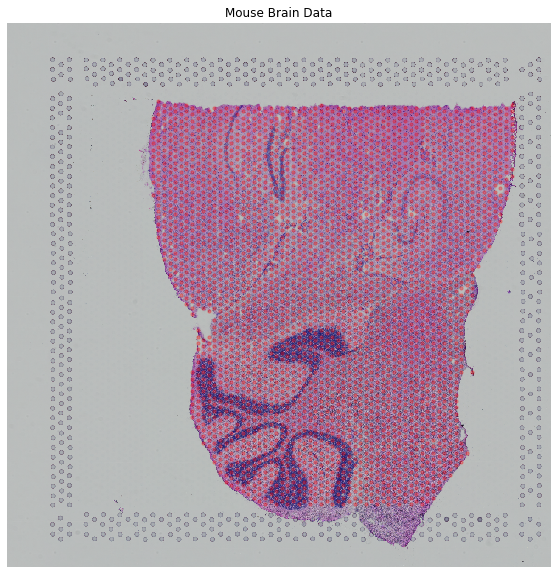

In [48]:
# Next, we visualize the data (HE image and spots)
fig,ax = plt.subplots(1,1,
                      figsize = (20,10))

plt_args = {"s":10, "c":"red",
            "alpha":0.3}

f.plot_data(ax,
            data,
            title = "Mouse Brain Data",
            show_image=True,
            plt_args = plt_args,
           )
plt.show()

We now cluster the data - again, using the same setup as before. Albeit our objective is not to study the clusters themselves, we will use them as a reference and basis in the upcoming analyses. The mouse brain is relatively diverse with several distinct spatial domains, so I've set the number of `gmm_components` to `10` here.

In [49]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans as km
from sklearn.decomposition import PCA
import umap

# set a random seed for reproducibility
np.random.seed(1337)

# normalize the expression data
y = f.naive_normalize(data.X)
# specify number of principal components to use in PCA, feel free to change!
pca_components = 20
# run PCA
y = PCA(n_components = pca_components).fit_transform(y)
# run UMAP
y = umap.UMAP(n_components = 2, random_state=13).fit_transform(y)
# specify the number of components in the GMM, feel free to change!
gmm_components  = 10
# fit GMM to the data
fitted_gmm = GMM(n_components = gmm_components, random_state=1).fit(y)
# get component weights for each spot, "soft labels"
labels_soft = fitted_gmm.predict_proba(y)
# get hard labels for each spot
labels_hard = np.argmax(labels_soft,
                        axis = 1)

as before we visualize the result of our clustering in UMAP-space, where we color observations (dots) by their cluster-label.

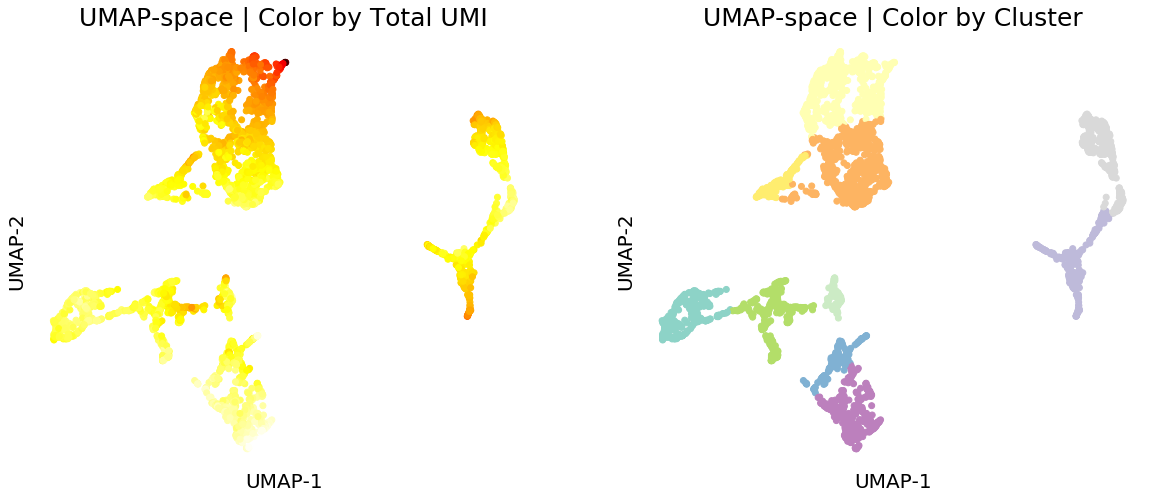

In [50]:
#------NON-CONCEPTUAL------#

fig,ax = plt.subplots(nrows = 1,
                      ncols = 2,
                      figsize = (20,10))

ax[0].scatter(y[:,0],
           y[:,1],
           c = np.log10(data.X.sum(axis=1).flatten()),
           cmap = plt.cm.hot,
          )
              
ax[0].set_aspect("equal")

ax[0].set_xlabel("UMAP-1",
                     fontsize = 20)
ax[0].set_ylabel("UMAP-2",
                     fontsize = 20)

f.clean_ax(ax[0])

    
ax[0].set_title("UMAP-space | Color by Total UMI",
                fontsize = 25)


# plot embedded data, color by hard labels
ax[1].scatter(y[:,0],
           y[:,1],
           c = labels_hard,
           cmap = plt.cm.Set3,
          )
ax[1].set_aspect("equal")

ax[1].set_xlabel("UMAP-1",
                     fontsize = 20)
ax[1].set_ylabel("UMAP-2",
                     fontsize = 20)

f.clean_ax(ax[1])

    
ax[1].set_title("UMAP-space | Color by Cluster",
                fontsize = 25)

plt.show()

<a id="cluster"></a>
Of course, we also inspect the cluster's spatial organization:

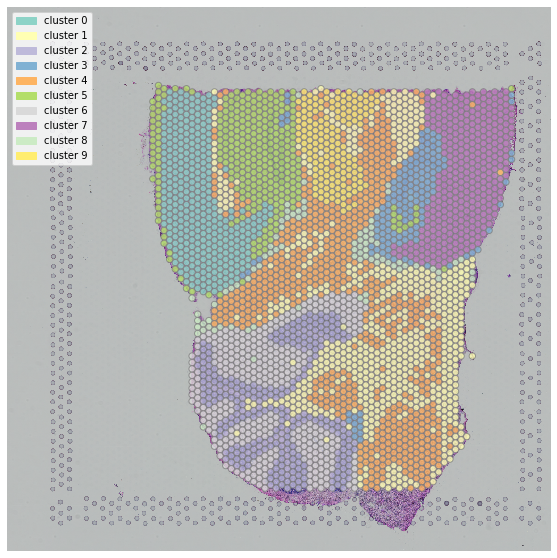

In [51]:
#------NON-CONCEPTUAL------#
import matplotlib.patches as mpatches

fig,ax = plt.subplots(nrows = 1,
                      ncols = 1,
                      figsize = (10,
                                 10))


f.plot_data(ax,
            data,
            plt_args = {"c":labels_hard,
                        "cmap":plt.cm.Set3,
                        "s":40,
                        "alpha":0.8,
                        "edgecolor":"gray",
                       },
            show_image = True,
           )

patches = list()
uni = np.unique(labels_hard)
for cl in uni:
    patches.append(mpatches.Patch(color=plt.cm.Set3(cl / uni.max()),
                                  label = "cluster {}".format(cl)))
ax.legend(handles = patches)
plt.show()

Now we have an idea of what the tissue looks like, and what sort of spatial domains/patterns we might expect to see in our analysis.

## 1. Spatial Enrichment

One question that naturally tends to arise when working with spatial data is whether there are any regions in the tissue that are _enriched_ for a certain biological pathway. We saw in Part 1 how we could first cluster the spatial data, and then subject each cluster to functional enrichment analysis (e.g., using `g:Profiler`). This approach however operates on a cluster-level, which severely reduces the spatial resolution; the optimal solution would be if could _relate an enrichment score to each spatial location (spot)_.


To exemplify, suppose we have a particular interest in a certain set of genes and want to know where it is spatially enriched. To answer this question we will consider a spot _enriched_ for a certain set of genes if it's members are overrepresented among the top expressed genes of that spot.

### Theory and Implementation

Let the $n_{top}$ genes in spot $s$ constitute a set $T_s$ and the genes in our set of interest be denoted $G$. The overlap, or _intersection_, between our two gene sets is then given by $T_s \cap G$. 

Next, we compute how likely we are to observe an intersection of the given size by chance - accounting for respective set's size and the total number of genes present in our data ($A$). 

<img src="imgs/venn.png">

We use [Fischer's Exact test][1] to compute the probability of observing $T_s \cap G$, resulting in a p-value ($p_s$) from which we construct an enrichment score ($E_s$) defined as :

\begin{equation}
    E_s = -\log10(p_s)
\end{equation}

Hence, each spot will have an enrichment score associated with it. 

I've written the function `enrichment_score` for you to compute these values. As you see from the function definition, you need to provide it with an `AnnData` object (argument `data`) and a list of genes (argument `genes`).

[1]:https://en.wikipedia.org/wiki/Fisher%27s_exact_test


In [52]:
#------NON-CONCEPTUAL------#

from scipy.stats import fisher_exact as fe

def enrichment_score(data : ad.AnnData,
                     genes : List[str],
                     n_top : float = 100,
                    )->np.ndarray:
    
    def _assemble_matrix(T : List[str],
                         G : List[str],
                         A : List[str],
                        )->np.ndarray:
        t = set(T)
        g = set(G)
        a = set(A)

        t_and_g = len(t.intersection(g))
        t_not_g = len(t.difference(g))
        g_not_t = len(g.difference(t))
        not_t_not_g = len(a.difference(t.union(g)))

        mat = np.array([[t_and_g,t_not_g],
                        [g_not_t,not_t_not_g]])
                
        return mat
    
    all_genes = data.var["name"].values
    gene_sums = np.sum(data.X, axis = 0)
    keep_genes = gene_sums > 0
    all_genes = all_genes[keep_genes]
    gene_sums = [keep_genes]
    
    escore = list()
    for s in range(data.shape[0]):
        expr = data.X[s,keep_genes]
        srt = np.argsort(expr)[::-1]
        
        cmat = _assemble_matrix(all_genes[srt[0:n_top]]\
                                .tolist(),
                                genes,
                                all_genes,
                               )
        _,pval = fe(cmat)
        escore.append(-np.log10(pval))
        
    escore = np.array(escore)
    
    return escore

### Analysis I

This approach works with _any_ set of genes, but for this example we'll stick to gene sets defined by certain GO terms.

Let us start by having a look at how the GO-term [`GO:0097060`][2] (_Cellular Component - Synaptic Membrane_) is spatially enriched within our tissue.

**COMMENT** : The files containing information regarding the gene sets are downloaded from gProfiler's [webpage][3].

[2]:http://amigo.geneontology.org/amigo/term/GO:0097060
[3]:https://biit.cs.ut.ee/gprofiler/convert


In [21]:
# set paths to files with GO term info
go_terms_pth = {"GO:0097060" : "rsc/go-0097060.csv",
                "GO:0042063" : "rsc/go-0042063.csv",
                "GO:0045202" : "rsc/go-0045202.csv",
               }

# read GO term info
go_terms = pd.read_csv(go_terms_pth["GO:0097060"],
                       sep = ',',
                       header = 0,
                       index_col = 0,
                      )

# get name of genes in GO term
go_terms = go_terms["name"]\
                    .values\
                    .tolist()

Then we compute the enrichment score:

In [25]:
# compute enrichment score
score = enrichment_score(data,
                         go_terms,
                         n_top = 200)

Now, having a score associated with each spatial location, we can plot the "spatial enrichment" of said GO term.

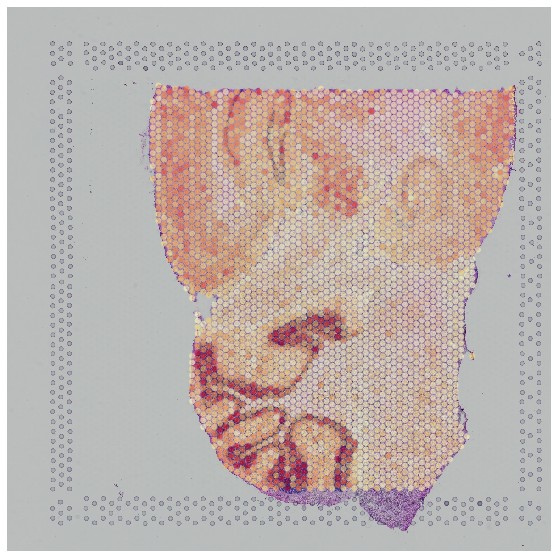

In [23]:
# visualize spatial enrichment
fig,ax = plt.subplots(1,1, figsize = (10,10))
f.plot_data(ax,
            data,
            plt_args = dict(c = score,
                            cmap = plt.cm.YlOrRd,
                            s = 35,
                            edgecolor = "none",
                            alpha = 0.6,
                           ),
           show_image = True,
           )

This type of analysis is to some extent _flipping_ the question - rather than having a pre-defined set of spots and asking "_which gene sets are enriched among these spots_", we formulate the much more targeted question "_where is this gene set enriched_". 

Both procedures are of course valid, but the former is  more prone to confirmation bias; testing against tens of thousands of pathways and finding one pathway that confirms your hypothesis should not be considered as equally strong evidence as **first stating** that "_if X is true then pathway P is should be enriched in this region_" and then proving that such is the case.

I've downloaded two more gene sets - in addition to `GO:0097060`. If interested, you can check out how they are spatially enriched by simply changing the key `"GO:0097060"` in `go_terms_pth["GO:0097060"]` to any of:

* "GO:0097060"
* "GO:0042063"
* "GO:0045202"

and then just rerun the cells above. 

## 2. Expression as a function of distance
I've said it before, but what's really neat with spatial data is that it allows us to relate our observations not only in the expression-space (like single cell data) but also in the physical space. Here we explore one of the ways by which this could be taken further advantage of.

### Motivation: 

Let us revisit the breast cancer data used in Part 1 and 2; suppose we had a pathologist annotating the regions of our tissue as *tumor* or *non-tumor* based on the visual inspection of the HE-image. Since the image is matched with our spatial locations, this would indirectly mean that every spot was also assigned one of these labels (inherited from the region which they fall within). 

With this information we could look at how the expression of certain genes vary based on the distance from the tumor/non-tumor interface. Relevant if we for example are interested in trying to characterize the _tumor microenvironment_ (TME). In theory, we might expect that to produce a graph that looks something like:

<img src="imgs/expression-by-distance.png">


Unfortunately, we don't have such annotations; so we stick with the mouse brain data and use [`cluster 2`](#cluster) as our reference point (instead of the tumor/non-tumor interface). 

### Implementation:

If we let the the set of spots belonging to `cluster k` be denoted as $C_k$ and its complement as $C_k^c$. Then, for each spot $s$ that is not a part of `cluster k` ($s \in C_k^c$) we define the distance to `cluster k` as, $d(s,C_k)$, as:

\begin{equation}
d(s,C_k) = \min_{s' \in C_k} ||x_s - x_{s'} ||
\end{equation}

Where $x_i$ are the spatial coordinates of spot $i$ and $||.||$ the euclidean norm. Our first task is to compute these distances, which in our particular case focusing on `cluster 2` are : $d(s,C_2) \forall s \in C_2^c$.

**NOTE** : Since the _actual distance_ is not really of interest to us, but we rather to know how a gene behaves "near" or "far" away from the tissue, we will map all of distances to the unit interval ($[0,1]$) by division with the maximal distance value. These values will be referred to as _relative distances_.


In [53]:
# set cluster of interest
cluster_of_interest = 2

# get spots in cluster 2 
in_c2 = labels_hard == cluster_of_interest
# get spots outside cluster 2
not_in_c2 = labels_hard != cluster_of_interest

# get all coordinates as array
crd = data.obs[["x","y"]].values

# compute distances between all spots in C2 and outside
dmat = cdist(crd[not_in_c2,:],crd[in_c2,:])
# prepare vector of minimum distances to C2
# spots in C2 are assigned nan values
dsc2 = np.ones(crd.shape[0])*np.nan
# for each spot, get distance to _nearest_
# spot in CS (aka. minimum distance to C2)
dsc2[not_in_c2] = np.min(dmat,axis =1)

# convert to relative distances
dsc2[not_in_c2] /= dsc2[not_in_c2].max()


We make sure that our distance values makes sense by coloring each spot by its distance to `cluster 2`

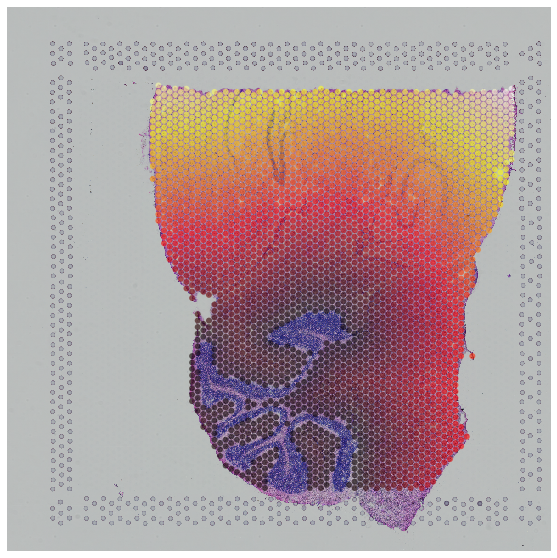

In [54]:
#------NON-CONCEPTUAL------#

fig,ax = plt.subplots(1,1, figsize = (10,10))
f.plot_data(ax,
            data,
            plt_args = dict(c = dsc2,
                            cmap = plt.cm.hot,
                            s = 35,
                            edgecolor = "none",
                            alpha = 0.6,
                           ),
           show_image = True,
           )

Indeed, the values check out. The further we move from spots belonging to `cluster 2` the higher our distance values are.


### Analysis
I've randomly picked three "genes of interest" (_Ndrg1_, _Dusp14_ and _Ddn_) for a demonstrative purpose as to give you an idea of what we can do with this information. 

To get a better sense of how our expression levels change over certain distances and the dynamics of this behavior; we make a _z-transformation_ within each spot. Meaning for the expression levels within each spot, we subtract the mean ($\mu$) and divide by the standard deviation ($\sigma$). 

In [55]:
# set genes of interest
# keys are indices in
# expression matrix
genes_of_interest = {19813: 'Scamp5',
                     25883: 'Ndrg1',
                     26413: 'Ddn'}

# get number of genes of interest
n_genes = len(genes_of_interest)

# compute spot-wise means
mu = data.X.mean(axis=1,
                 keepdims=True)

# compute spot-wise standard deviation
sigma = data.X.std(axis=1,
                   keepdims=True)

# normalize data
n_expr = (data.X - mu) / sigma

Finally, we now proceed to plot the expression values of our genes of interest against their distance to `cluster 2`.

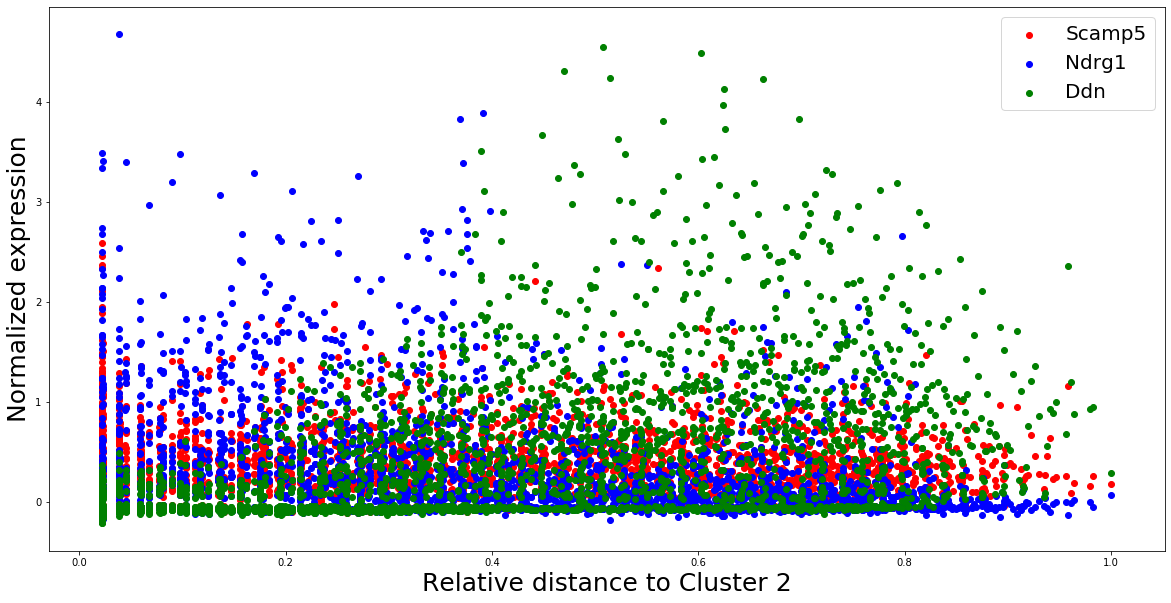

In [56]:
# set colormap
colors = ["red","blue","green"]

# generate Figure and Axis object
fig,ax = plt.subplots(1,1, figsize = (20,10))

# Plot gene expression as function of distance
for k,g in enumerate(genes_of_interest.keys()):
    ax.scatter(dsc2[not_in_c2],
               n_expr[not_in_c2,g],
               c = colors[k],
               label = genes_of_interest[g],
              )
    ax.set_xlabel("Relative distance to Cluster 2",
                  fontsize =25)
    
    ax.set_ylabel("Normalized expression",
                  fontsize = 25)

ax.legend(fontsize = 20)
plt.show()

As you see, it's a complete mess. This is the type of plot you shrug at when included in a publication.

Therefore, to make this information a bit more approachable, we will fit a curve to the data, with the aim to better be able to make a statement regarding the behavior of these genes. More precisely, we formulate this as a regression problem where observations are modeled as realizations of a [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) (GP). Any choice of regression method (e.g., _loess_ ) would of course be equally valid. 

We use `sklearn`'s [implementation](https://scikit-learn.org/stable/modules/gaussian_process.html) of GP regression, with a _RBF_ kernel for the covariance matrix (basically this defines how we relate the different observations to each other). For more information regarding GP's and the implementation, see the linked resources above.


For each of our three genes, we fit a GP and then predict the mean realative expresssion (`y_mu`) at unobserved distances (`xx`). Using GP's, we will also obtain a metric of confidence (standard deviation, `y_std`) associated with each of our predictions. 


In [59]:
# import necessary classes
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from sklearn.gaussian_process.kernels import RBF



# list to store values data
y_stds = list()
y_mus = list()

# set distances to predict expression at
xx = np.linspace(dsc2[not_in_c2].min(),
                 dsc2[not_in_c2].max(),
                 1000)


for g in genes_of_interest.keys():
    # define RBF kernel
    kernel = RBF(1,length_scale_bounds=(1e-1, 50.0))
    # instatiate and fit GP
    gpr = GP(kernel=kernel,
             random_state=0)\
          .fit(dsc2[not_in_c2,np.newaxis],
               n_expr[not_in_c2,g])
    
    # predict mean and get std
    y_mu,y_std = gpr.predict(xx[:,np.newaxis],
                            return_std=True)
    
    # save predictions
    y_mus.append(y_mu.reshape(-1,))
    y_stds.append(y_std.reshape(-1,))

Let us now make a second attempt to visualize the expression as a function of distance, but this time using the results from our regression analysis. 

Regions within $2$ standard deviations of the mean by a semi-transparent coloring. I've also included the raw values as a reference (in the background).

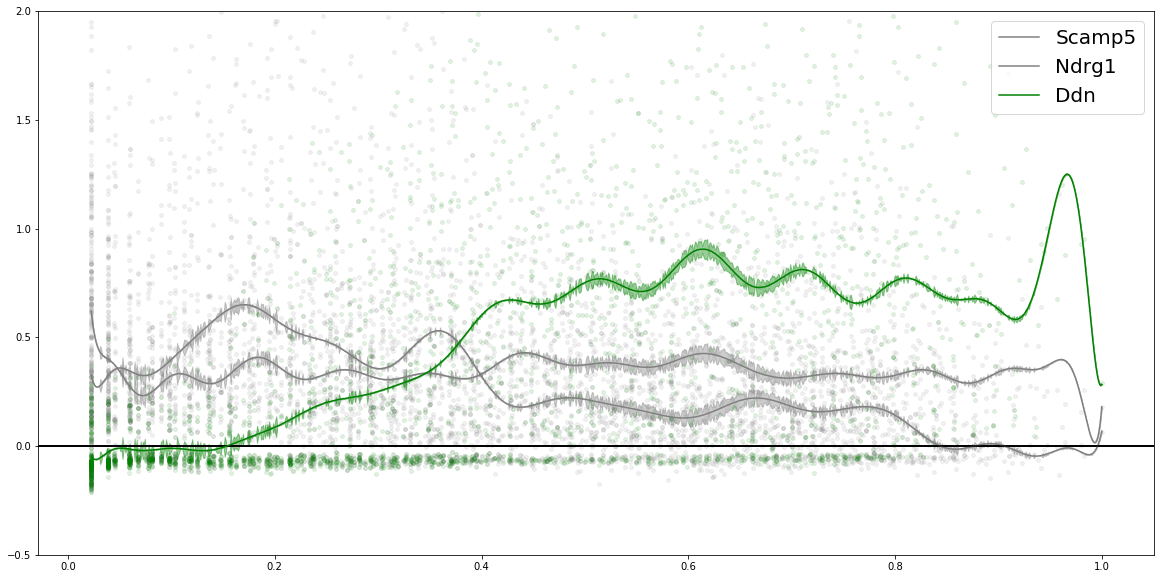

In [63]:
#------NON-CONCEPTUAL------#

fig,ax = plt.subplots(nrows = 1,
                      ncols = 1,
                      figsize = (20,10))

for k,(g,name) in enumerate(genes_of_interest.items()):
    
    ax.axhline(y = 0,
               c = "black")
    
    ax.fill_between(xx,
                    y_mus[k] - 2*y_stds[k],
                    y_mus[k] + 2*y_stds[k],
                    color = colors[k],
                    alpha = 0.4)
    
    sc = ax.scatter(dsc2[not_in_c2],
                    n_expr[not_in_c2,g],
                    c = colors[k],
                    alpha = 0.1,
                    s = 15,
                    )
    
    ax.plot(xx,
            y_mus[k],
            c = colors[k],
            label = name,
            )
    
ax.set_ylim(-0.5,2)

ax.legend(fontsize = 20)

plt.show()

Now this plot is a bit more digestible and easier to interpret.

For example, we immediately see that the expression levels of <span style="color:blue;font-weight:bold"> _Ndrg1_</span> are elevated near `cluster 2` but tends to be decrease as one moves away from it. The opposite seems to b true for <span style="color:green;font-weight:bold">_Ddn_</span>. Expression levels of <span style="color:red;font-weight:bold">_Scamp_</span> however seems to be fairly evenly expressed at different distances to the cluster.

Plotting the spatial gene expression of these genes, we can confirm that these conclusions are true; expression levels are given in <span style="color:red">red</span> while members of `cluster 2` are given in black. 

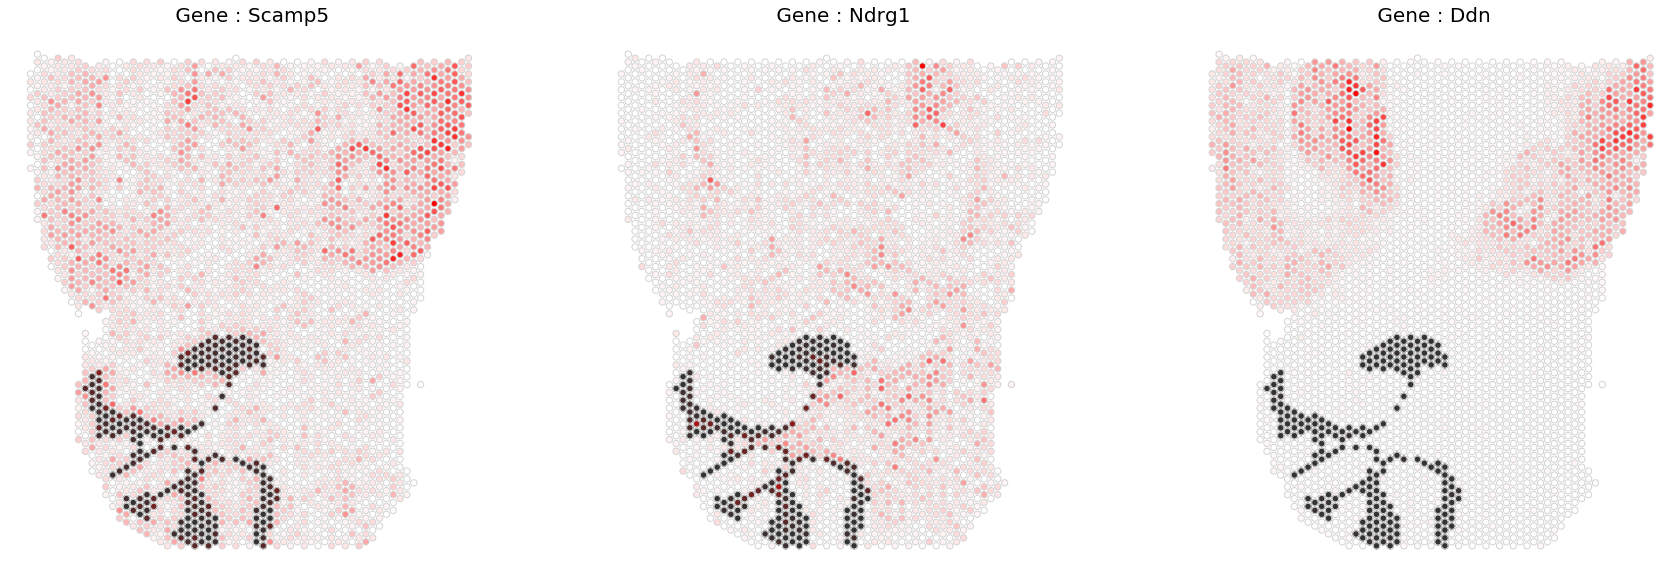

In [50]:
#------NON-CONCEPTUAL------#

fig,ax = plt.subplots(1,3, figsize = (30,10))
ref = np.ones(data.shape[0])
ref[not_in_c2] = np.nan

for k,gene in enumerate(genes_of_interest.values()):
    f.plot_data(ax[k],
              data,
              plt_args = {"cmap":plt.cm.bone,
                          "s":40,
                          "c":ref,
                         },
              title = " Gene : {}".format(gene),
              show_image = False,
              clean = True)
    
    f.plot_data(ax[k],
              data,
              feature = ["name",gene],
              plt_args = {"cmap":"feature",
                          "s":40,
                          "edgecolor" :"lightgray",
                         },
              show_image = False,
              clean = True)
    
    ax[k].invert_yaxis()
    
    ax[k].set_title(" Gene : {}".format(gene),
                    fontsize = 20)
    

Now when we've gotten familiar with the concept of _"expression by distance"_, we're in a position to make some more targeted analysis.

### Analysis II
Assume that we are interested in knowing which genes that are mainly expressed along the edges of `cluster 2` (relating back to the breast cancer data, this would in theory represent the TME-genes). This question can of course be approached in several ways, we will however stick with a very basic solution that's easy to implement. Being:

We reformulate the problem ever so slightly by first defining a threshold $\epsilon \in (0,100)$, and then ask which genes that have $\epsilon\%$ of their total expression within the shortest distance from`cluster 2`. 

<img src="imgs/integral.png" width="50%" height="50%">

If we let $f(x)$ represent the expression (as a function of the relative distance, $x$), then finding the distance ($d_g$) where $\epsilon\%$ of the total expression of gene $g$ is contained, equates to solving the equation (w.r.t. $d_g$):

\begin{equation}
    \frac{\epsilon}{100} = \frac{\int_0^{d_g} f(x)dx}{\int_0^1f(x)dx}
\end{equation}

Working with discrete data, we will approximate this $d_g$ as the distance to the first spot for which the total gene expression of all spots closer to `cluster 2` than this spot makes up $\epsilon\%$ of the gene's total expression value. 

Here $\epsilon$ is set to $50%$ but feel free to play around with that value. Only genes with more than a total of $100$ UMI's will be considered; very lowly expressed genes have a tendency to produce quite funky results.

In [64]:
#------NON-CONCEPTUAL------#

# set epsilon
eps = 50.0
# set umi threshold
umi_thrs = 100

# sort spot by distances
srt_dist = np.argsort(dsc2)

# get cumulative sums for expression
cs = np.cumsum(data.X[srt_dist,:],
               axis = 0,
              )
# compute fraction of total gene expression at each distance
fracs = (cs / cs[-1,:] > (eps/100)) * (cs[-1,:] > umi_thrs)

# find distances where epsilon % of expression
# is contained within
dgs = np.argmax(fracs,
                axis=0,
               )

# adjust for lowly expressed genes 
dgs[dgs == 0] = dgs.max()

Let us inspect the ten genes with smallest $d_g$ :

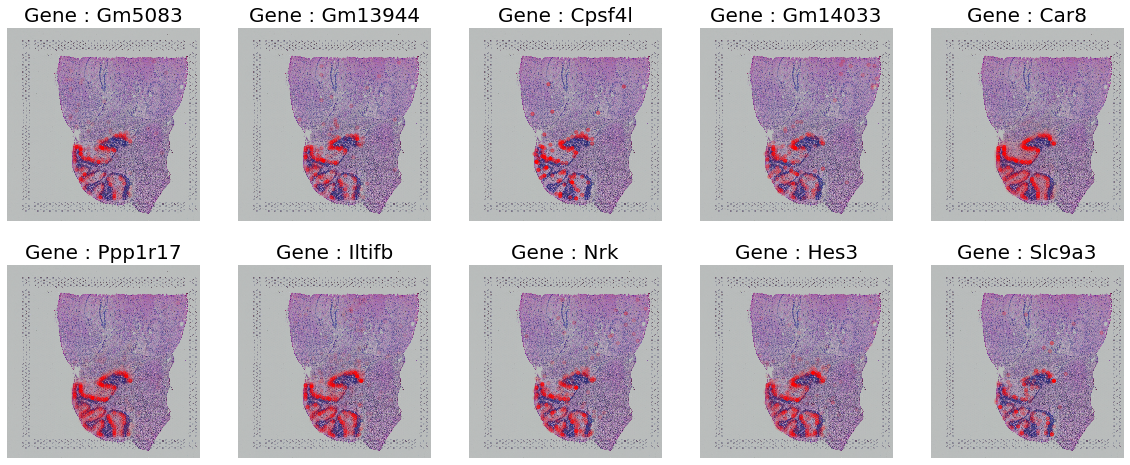

In [66]:
# set number of genes to display
n_top = 10
# get indices of number of genes
top_n_genes = np.argsort(dgs)[0:n_top]

# figure setup
n_rows = 2
n_cols = int(np.ceil(n_top/n_rows))

fig,ax = plt.subplots(n_rows,
                      n_cols,figsize=(20,8))
ax = ax.flatten()

# plot expression of the 10 genes
# with epsilon % of expression within
# shortest distance to cluster

for k,idx in enumerate(top_n_genes):
    gene = data.var["name"].values[idx]
    f.plot_data(ax[k],
              data,
              feature = ["name",gene],
              plt_args = {"cmap":"feature",
                          "s":10,
                         },
              show_image = True,
              clean = True)
    ax[k].set_title("Gene : {}".format(gene),
                   fontsize = 20,
                   )

This is not too bad, the genes we observe really do trace the edges of`cluster 2`. With more "interesting" questions or spatial domains (like tumor annotations) this could potentially offer some informative insights. 

Having achieved what we set out to do, we wrap up this example here.

## 3. Increased Spatial Resolution  (Primer)


### Motivation
Now, jumping back to the [initial data assessment](#cluster); suppose we are interested the genes associated with `cluster 0` and decide to conduct a DE analysis to see which genes that are associated with this particular domain. We can use the function written in Part 1 (`dge_test`) for this; which I've included in the `funcs` module.

In [12]:
# conduct DE test
dge_res = f.dge_test(data,
                     labels_hard,
                     contrast = 0,
                    )

We then inspect our results:

In [13]:
display(dge_res.head(10))

pval       pval_adj      l2fc  sig
Satb2          2.565181e-252  5.748570e-249  4.264003    1
Tbr1           7.196036e-205  8.063158e-202  3.214655    1
1110008P14Rik  2.038219e-165  1.522550e-162  1.667736    1
3110035E14Rik  1.026356e-157  5.750159e-155  2.700458    1
Ngef           7.708745e-143  3.455059e-140  2.033117    1
Pde1a          1.026263e-131  3.285509e-129  1.934912    1
Chn1           3.964746e-126  1.110625e-123  1.354866    1
Fhl2           6.251482e-115  1.556619e-112  2.225640    1
Ier5           3.932390e-105  8.812487e-103  1.853498    1
Kcnh7          4.388056e-105  8.939666e-103  2.168241    1

From this it seems as if the gene `Satb2` is upregulated in `cluster 0`. To confirm this we visualize the expression of said gene:

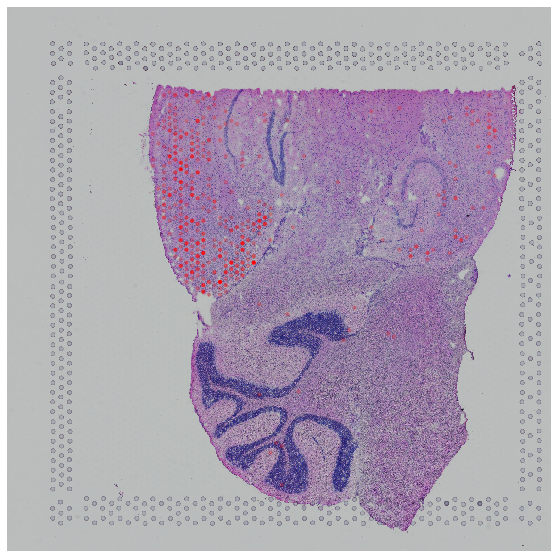

In [67]:
#------NON-CONCEPTUAL------#

fig,ax = plt.subplots(1,1, figsize = (10,10))
f.plot_data(ax,
            data,
            feature=["name","Satb2"],
            plt_args = dict(cmap = "feature",s = 10))

The expression seems to overlap well with the cluster region, but it's a very sparse pattern, which makes it hard for us to distinguish any precise features. We therefore pose the question of whether we could learn the spatial structure of our data and then "fill in the gaps"; both between the spots and in those locations where we might have a dropout (i.e. transcripts were not captured even though present). 


### Implementation
As eluded to above, the what we would like to do is to somehow learn the spatial structure of our data from the few datapoints that we have observed in order to make an informed statement of the expression at those locations where we are missing data. To predict gene expression in the regions between spots, we could simply do a linear interpolation; something in the spirit of _"take the weighted average of the six nearest neighbours"_ . But what if there are more "long distance" relationships within our tissue, perhaps the expression of one region is informative of a more distant region than it's closest neighbours (a good example of this would be if we had an axis of symmetry present in our tissue)?

In order to account for the expression across the whole tissue and model non-linear relationships we will use a _neural network_ (NN), trained to predict _expression based on location_. The idea is that we train our network with the known locations and expression values, to then predict expression values for new locations (e.g., between the spots). 

<img src="imgs/preds.png" width="50%" height="50%">


We implement the network in [PyTorch][1], an open source machine learning library, which provides a neat framework for building your own ML-models. PyTorch (superficially) shares many features with the (perhaps) more familiar [TensorFlow][2].

As input to our network, we compute the euclidean distances between all spots and transform these to more "smooth values" (less prone to blow up our network) by applying a _RBF_ kernel, producing the transformed distances $(w_s)$.

The raw expression values ($x_{gs}$) will also be transformed to new values ($y_{gs}$), according to $y_{gs} = \log2{(x_{gs} + 1)}$. Our network has two (fully connected) hidden layers, and uses _Mean Squared Error_ as loss function. I've inentionally tried to make this network very lightweight, to allow CPU based computing and low memory load.

<img src="imgs/nn.png" width="25%" height="25%">

While PyTorch is fairly easy to use, there's some infrastructure that needs to be put in place. You need a `Dataset` class to hold you data, with two required methods: `__getitem__` and `__len__`. You also need a `fit` function, that performs the actual training. To save you some time, I've already written these components for you - meaning it's more "plug and play"; but do feel free to have a look and explore them. 

Our `Dataset` class will be named `SpatialData`, the function to fit our data is simply named `fit`, and the network class `GeneNet`. 

[1]:https://pytorch.org/
[2]:https://www.tensorflow.org/

In [68]:
#------NON-CONCEPTUAL------#

class SpatialData(Dataset):
    def __init__(self,
                 data : ad.AnnData,
                 sigma : float = 0.001, 
                 ):


        self.visual = data.uns

        self.sigma = sigma
        self.obs = data.obs.index.values

        self.genes = data.var["name"].tolist()

        self.crd = data.obs[["x","y"]].values

        self.sf = 1

        self.wmat = self.dist_fun(self.crd,
                                  set_sf=True)

        self.max_val = data.X.max()

        expr  = self.normalize_data(data.X)

        self.expr = expr
        self.S = self.expr.shape[0]
        self.G = self.expr.shape[1]

        self.active = 0

        self.g2p  = {self.genes[k]:k for k in range(self.G)}

    def normalize_data(self,
                       x : np.ndarray):
        
        xl = np.log2(x + 1)
        tmp = t.tensor(xl.astype(np.float32))

        return tmp
    

    def dist_fun(self,x : np.ndarray,
                 set_sf : bool = False,
                )-> t.tensor:

        wmat = cdist(x,self.crd)
        if set_sf:
            self.sf = wmat.max()

        wmat = wmat / self.sf

        wmat = np.exp((-(wmat ** 2)/(2*self.sigma)))

        wmat = t.tensor(wmat.astype(np.float32))

        return wmat

    def set_active(self,
                   gene : str,
                   )->None:

        if gene in self.genes:
            self.active = self.g2p[gene]
        else:
            print("not a valid gene name")

    def __getitem__(self,x)->Dict[str,t.tensor]:
        return dict(dist = self.wmat[x,:],
                    expr = self.expr[x,self.active])


    def __len__(self,):
        return self.S
    
    
class GeneNet(nn.Module):
    def __init__(self,
                 input_size,
                 drop_p=0.5,
                 **kwargs,
                 )->None:

        super(GeneNet,self).__init__()
        self.input_size = input_size
        self.drop_p = drop_p

        self.nh1 =  kwargs.get("hidden1",64)
        self.nh2 = kwargs.get("hidden2",32)

        self.fc1 = nn.Linear(self.input_size,
                             self.nh1)

        self.a1 = kwargs.get("activation1",
                             nn.ReLU())
        self.a2 = kwargs.get("activation2",
                             nn.ReLU())


        self.drop = nn.Dropout(p = drop_p)

        self.fc2 = nn.Linear(self.nh1,self.nh2)
        self.fc3 = nn.Linear(self.nh2,1)
        self.out = nn.Softplus()

    def forward(self,
                x : t.tensor,
               )-> t.tensor:
        
        y = self.fc1(x)
        y = self.a1(y)
        y = self.drop(y)
        y = self.fc2(y)
        y = self.a2(y)
        y = self.drop(y)
        y = self.fc3(y)

        return self.out(y.view(-1))


def fit(train_loader : DataLoader,
        model : SpatialData,
        n_epochs : int = 100,
        )->Tuple[SpatialData,List[float]]:

    train_loss = []
    lfun = nn.MSELoss()
    opt = optim.Adam(model.parameters(),
                           lr =0.001)

    model.train()

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch in train_loader:
            opt.zero_grad()
            output = model(batch["dist"])
            
            loss = lfun(output,
                        batch["expr"])
            
            
            loss.backward()
            opt.step()
            epoch_loss += loss.item()

        train_loss.append(epoch_loss)
        if epoch % 100 == 0:
            print("Epoch {} | Loss {}"\
                  .format(epoch,epoch_loss))

    return model,train_loss



### Analysis

The classes above are written as to allow you to play around with the number of nodes and activation functions, but for this initial test, we'll use the following settings:

* 64 nodes in the first hidden layer
* 32 nodes in the second hidden layer
* 500 epochs

To train the network on the gene `Satb2` you need to set this as the "active" gene in the SpatialData object (`xdata`), When that is done, we are ready to assemble and train our network (`net`).

In [69]:
#------NON-CONCEPTUAL------#

# specify number of epochs (full pass of training data)
t.manual_seed(1337)
n_epochs = 500

# specify number of nodes in the hidden layers
n_h1 = 64
n_h2 = 32

# create a SpatialData object to hold data
xdata = SpatialData(data,
                    sigma=0.01)

batch_size = 1024

# set "Satb2" as the gene to be trained on
xdata.set_active("Satb2")
# define a train loader that feeds data to
# the network (handles batching etc.)
train_loader = DataLoader(xdata,
                        batch_size = batch_size)

# assemble the network
net = GeneNet(input_size = xdata.S,
              drop_p = 0.5,
              hidden1 = n_h1,
              hidden2 = n_h2,
             )


In [70]:
# Train the network!
net,_ = fit(train_loader,
            model = net,
            n_epochs=n_epochs)

Epoch 0 | Loss 1.4650078117847443
Epoch 100 | Loss 0.389049232006073
Epoch 200 | Loss 0.35750461742281914
Epoch 300 | Loss 0.3678104057908058
Epoch 400 | Loss 0.3582431171089411


Great! Now when our network is trained, we're ready to use it for our intended purpose; to obtain a higher resolution of the gene expression.

All that remains to be done is to generate a transformed distance vector for each location that we want to predict the expression value at and then pass each of these vectors through our trained vector.  The `Interpolator` class below will do just this for you.

When instantiating an `Interpolator`object, provide the `SpatialData` object used to train the network, and the number of spots you want along each dimension (if you max out to hard on this, the number of spots, you might experience some memory issues). 

In [75]:
#------NON-CONCEPTUAL------#

class Interpolator:
    def __init__(self,
                 dl : SpatialData,
                 n_points : int = 200,
                 ):

        _x =  np.linspace(dl.crd[:,0].min(),
                          dl.crd[:,0].max(),
                          n_points)

        _y =  np.linspace(dl.crd[:,1].min(),
                          dl.crd[:,1].max(),
                          n_points)


        _x,_y = np.meshgrid(_x,_y)
        self.crd = np.hstack((_x.reshape(-1,1),
                              _y.reshape(-1,1)))

        self.wmat = dl.dist_fun(self.crd)

    def predict(self,
                model : GeneNet,
                ):
        
        model.eval()
        self.values = model(self.wmat)\
            .detach()\
            .numpy()\
            .reshape(-1,)
        
        self.values[self.wmat.numpy().max(axis=1) < 0.995] = np.nan


In [72]:
# create an interpolator object
inter = Interpolator(xdata,
                     n_points=400)

Next, for the actual prediction, we use the `predict` method of our `Interpolator` object, providing the trained network (`net`) as the argument.

In [73]:
# predict expression at unobserved locations
inter.predict(net)

Finally we visualize our results, and compare it with the observed expression values.

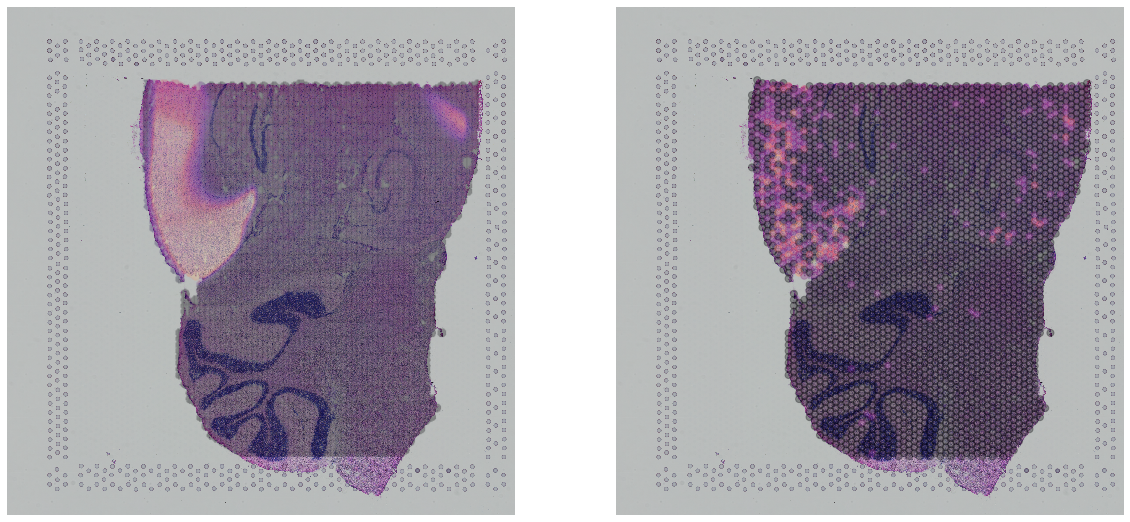

In [74]:
#------NON-CONCEPTUAL------#

cmap = plt.cm.Blues
fig,ax = plt.subplots(1,2,figsize=(20,10))

# predction data
ax[0].imshow(xdata.visual["image_hires"].transpose(1,0,2))

ax[0].scatter(inter.crd[:,0]*xdata.visual["tissue_hires_scalef"],
              inter.crd[:,1]*xdata.visual["tissue_hires_scalef"],
              c=inter.values,
              s = 0.01,
              cmap = cmap,
              alpha = 0.8,
              )
# raw data
ax[1].imshow(xdata.visual["image_hires"].transpose(1,0,2))
ax[1].scatter(xdata.crd[:,0]*xdata.visual["tissue_hires_scalef"],
            xdata.crd[:,1]*xdata.visual["tissue_hires_scalef"],
            c=xdata.expr[:,xdata.active].numpy(),
            s =50,
            cmap = cmap,
            alpha = 0.3)

for ii in range(2): 
    ax[ii].set_aspect("equal")
    f.clean_ax(ax[ii])
    
plt.show()


There are quite a lot of parameters that could be tweaked here, (number of neurons, activation functions, loss function, epochs, learning rate etc..) - in a more rigorous analysis, we would also prefer to split the data into a training and validation set (to guard ourselves of overfitting) which for sure happens here. Still, based on the results from this very naivë approach, one might say that there is some potential for this idea of learning spatial structure.

However, if we attempt to analyze a gene with a slightly more irregular expression pattern, like `Car8` (up-regulated in cluster 2), it's obvious that there are some sub-optimal performance with our method.

**NOTE** : Feel encouraged to change and play around with the network hyperparameters, see if you can improve the performance.

In [76]:
from torch.nn import ReLU, ELU, Sigmoid, CELU
t.manual_seed(1337)

# set the active gene to Car8
xdata.set_active("Car8")

# set network and training settings
n_epochs = 2000

# network hyperparameters
n_h1 = 64
n_h2 = 32
act_1 = ReLU()
act_2 = ReLU()

# assemble network
net = GeneNet(input_size = xdata.S,
              hidden1 = n_h1,
              hidden2 = n_h2,
              activation1 = act_1,
              activation2 = act_2,
              drop_p = 0.2,
             )

Having defined our network, we then proceed to train it.

In [77]:
# train network for Car8
net,loss = fit(train_loader,
               model = net,
               n_epochs=n_epochs)

Epoch 0 | Loss 8.235918551683426
Epoch 100 | Loss 2.9297744184732437
Epoch 200 | Loss 2.783556491136551
Epoch 300 | Loss 2.7297565937042236
Epoch 400 | Loss 2.6559211015701294
Epoch 500 | Loss 2.4931644648313522
Epoch 600 | Loss 2.449680835008621
Epoch 700 | Loss 2.468057483434677
Epoch 800 | Loss 2.4550862312316895
Epoch 900 | Loss 2.287797510623932
Epoch 1000 | Loss 2.3178222328424454
Epoch 1100 | Loss 2.2204042226076126
Epoch 1200 | Loss 2.2096159607172012
Epoch 1300 | Loss 2.145768404006958
Epoch 1400 | Loss 2.1424208730459213
Epoch 1500 | Loss 2.123972177505493
Epoch 1600 | Loss 2.1248599886894226
Epoch 1700 | Loss 2.0630443394184113
Epoch 1800 | Loss 2.086349308490753
Epoch 1900 | Loss 2.168854370713234


Followed by a prediction

In [78]:
# predct gene expression using the trained network
inter.predict(net)

And finally a visualization

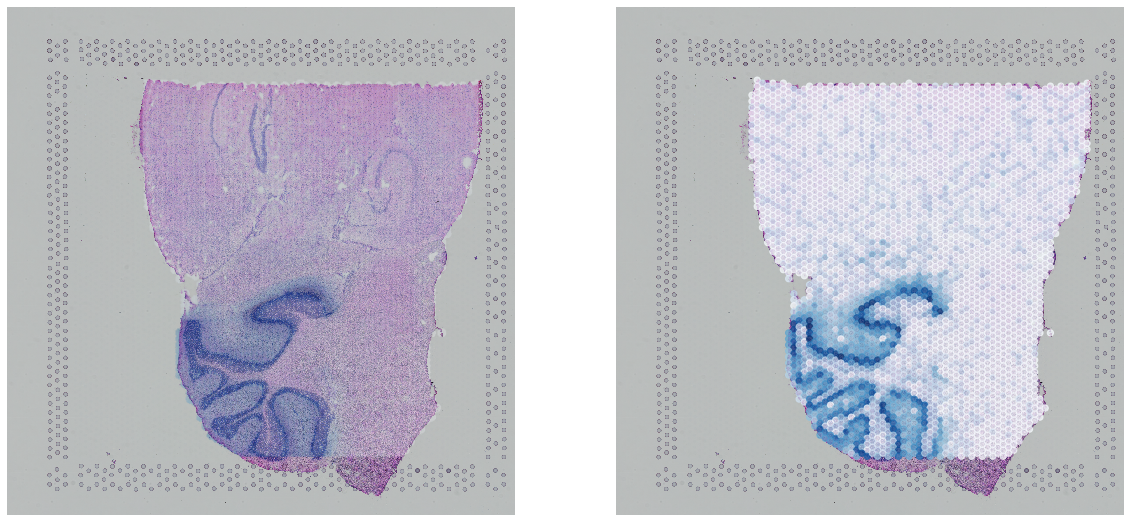

In [81]:
#------NON-CONCEPTUAL------#
cmap = plt.cm.Blues
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(xdata.visual["image_hires"].transpose(1,0,2))
ax[0].scatter(inter.crd[:,0]*xdata.visual["tissue_hires_scalef"],
              inter.crd[:,1]*xdata.visual["tissue_hires_scalef"],
              c=inter.values,
              s = 0.01,
              cmap = cmap,
              alpha = 0.8,
              )

ax[1].imshow(xdata.visual["image_hires"].transpose(1,0,2))
ax[1].scatter(xdata.crd[:,0]*xdata.visual["tissue_hires_scalef"],
            xdata.crd[:,1]*xdata.visual["tissue_hires_scalef"],
            c=xdata.expr[:,xdata.active].numpy(),
            s =40,
            cmap = cmap,
            alpha = 0.7)

for ii in range(2): 
    ax[ii].set_aspect("equal")
    f.clean_ax(ax[ii])
plt.show()

Not really that promising... We do capture some of structure of the gene expression, but the gradient along the edges of the darker area is partially lost. More training would increase the performance somewhat, and as mentioned above, we could start tweaking the settings and changing the architecture of our network (try it out!).

There is however one thing we have not discussed yet, namely the HE-image. The HE-image is extremely rich in information, for example; we have clearly seen how the expression based clusters relate to the morphology observed in the image. If we somehow could base our inference on the joint information presented by the image and gene expression, we could probably do much better than this.

We will not embark upon that endeavour in this exercise, but there exist a method designed for this specific purpose, developed by L. Bergenstråhle et.al (a member of our Lab).

The implementation is named **xFuse** and found [here](https://github.com/ludvb/xfuse). To illustrate some of the results that you can achieve I've included one of the main figures from the [preprint](https://www.biorxiv.org/content/10.1101/2020.02.28.963413v1.full) below:

<img src = "imgs/xfuse.png">

If these results and the ideas behind them intrigue you, then I highly recommend to give **xFuse** a look and try it out on you data.

## Wrapping Up

This is the final of the 3 exercises. I hope you've enjoyed working through the material and have added at least one or two new tools/ideas to your arsenal for analysis of spatial data. 